## Import Package and Build Function

In [ ]:
!pip install scipy

In [ ]:
#from CommonClasses.fft import * # Tidak digunakan karna ada beberapa kode yang deprecated
from numpy import binary_repr

from scipy import fft # Pengganti CommonClasses.fft

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import cmath
import time
import csv

In [ ]:
def constructDuv(N):
  # Matriks frekuensi berukuran NxN
  u = np.arange(N)
  v = np.arange(N)

  # Fourier Shift -> dilakukan agar frekuensi tinggi dipindahkan ke ujung kiri/bawah dan frekuensi rendah tetap di tengah
  idx = np.where(u>N/2)[0]
  u[idx] = u[idx] - N
  idy = np.where(v>N/2)[0]
  v[idy] = v[idy] - N

  [V,U] = np.meshgrid(v,u) # Digunakan untuk menghasilkan grid 2 dimensi
  D = np.sqrt(U**2 + V**2) # Rumus Euclidean untuk menghitung jarak

  return D

In [ ]:
def computeFilteredImage(H, F):
  G = H * F # H -> Filter dalam domain frekuensi, F -> Gambar yang telah ditransformasi menggunakan FFT
  g = np.real(fft.ifft2(G)).astype(int)
  return g

Fungsi Ideal Filtering

In [ ]:
def computeIdealFiltering (D, Do, mode=0): # Membuat filter Ideal
  H = np.zeros_like(D) # Membuat array dengan inisialisasi dengan nilai 0
  if mode==0:
    # True -> mengembalikan nilai 1 dalam bentuk boolean. False -> mengembalikan nilai 0 dalam bentuk boolean
    H = (D<=Do).astype(int) # Lowpass
  else:
    H = (D>Do).astype(int) # Highpass
  return H

In [ ]:
def computeIdealFilters (image, F, D, Dos):
  gsLP = []
  gsHP = []
  IRunningTime = []

  for Do in Dos:
    startTime = time.time()

    H = computeIdealFiltering(D, Do, 0) # Lowpass
    IRunningTime.append((time.time() - startTime))
    gsLP.append(computeFilteredImage(H, F)) # Inverse Fourier

    H = computeIdealFiltering(D, Do, 1) # Highpass
    gsHP.append(computeFilteredImage(H, F))

  return gsLP, gsHP, IRunningTime

Fungsi Butterworth Filtering

1. D = Jarak yang dihasilkan dari fungsi ConstructDuv
2. Dos = Nilai frekuensi batas (cut-off frequency), digunakan untuk melemahkan sinyal representasi data pada gambar. Lowpass -> Nilai frekuensi diatas frekuensi batas akan dilemahkan, Highpass -> Nilai frekuensi dibawah frekuensi batas akan dilemahkan
3. n/ns = Nilai order, untuk mempengaruhi seberapa cepat atau lambat filter dapat melemahkan frekuensi gambar. Nilai order akan mengontrol ketajaman respons filter di sekitar frekuensi batas



In [ ]:
def computeButterworthFiltering(D, Do, n, mode=0): # Membuat filter Butterworth
  H = np.zeros_like(D)
  D = D.astype(float)

  if mode==0:
    H = 1.0/(1.0 + ((D/Do)**(2*n))) # Lowpass
  else:
    H = 1.0/(1.0 + ((Do/D)**(2*n))) # Highpass
  return H

In [ ]:
def computeButterFilters(image, F, D, Dos, ns):
  gsLP = []
  gsHP = []
  BRunningTime = []

  for i, Do in enumerate(Dos):
    startTime = time.time()

    H = computeButterworthFiltering(D, Do, ns[i], 0) # Lowpass
    BRunningTime.append((time.time() - startTime))
    gsLP.append(computeFilteredImage(H, F)) # Inverse Fourier

    H = computeButterworthFiltering(D, Do, ns[i], 1) # Highpass
    gsHP.append(computeFilteredImage(H, F))

  return gsLP, gsHP, BRunningTime

Fungsi visualisasi

In [ ]:
def visualizeFilteringResults(imge, F, gsLP, gsHP, Dos, filterType="Ideal", ns=None):

    fig, axarr = plt.subplots(2, 5, figsize=[12,6])

    axarr[0, 0].imshow(imge, cmap=plt.get_cmap('gray'), )
    axarr[0, 0].set_title("Original Image", fontsize=10, pad=10)
    axarr[0, 0].axes.get_xaxis().set_visible(False)
    axarr[0, 0].axes.get_yaxis().set_visible(False)

    axarr[1, 0].imshow(imge, cmap=plt.get_cmap('gray'))
    axarr[1, 0].set_title("Original Image", fontsize=10, pad=10)
    axarr[1, 0].axes.get_xaxis().set_visible(False)
    axarr[1, 0].axes.get_yaxis().set_visible(False)

    for i, g in enumerate(gsLP):
        if filterType=='Ideal':
            lp = "ILPF(Do="+str(Dos[i])+")"
            hp = "IHPF(Do="+str(Dos[i])+")"
        else: # Butterworth
            lp = "BLPF(Do="+str(Dos[i])+",n="+str(ns[i])+")"
            hp = "BHPF(Do="+str(Dos[i])+",n="+str(ns[i])+")"

        axarr[0, i+1].imshow(gsLP[i], cmap=plt.get_cmap('gray'))
        axarr[0, i+1].set_title(lp, fontsize=9, pad=5)
        axarr[0, i+1].axes.get_xaxis().set_visible(False)
        axarr[0, i+1].axes.get_yaxis().set_visible(False)

        axarr[1, i+1].imshow(gsHP[i], cmap=plt.get_cmap('gray'))
        axarr[1, i+1].set_title(hp,fontsize=9, pad=5)
        axarr[1, i+1].axes.get_xaxis().set_visible(False)
        axarr[1, i+1].axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

## Apply Ideal Filtering and Butterworth Filtering

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving istockphoto-1431404669-1024x1024.jpg to istockphoto-1431404669-1024x1024.jpg


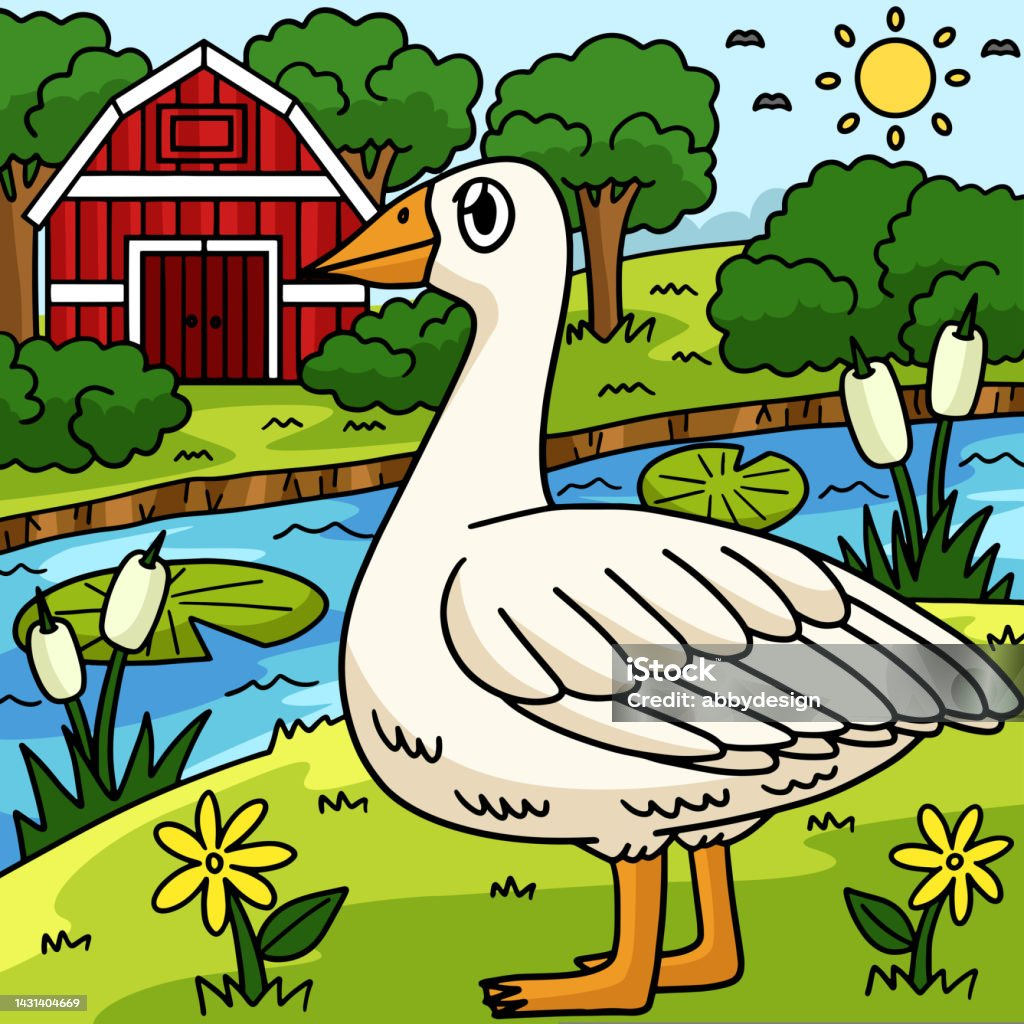

In [ ]:
image = Image.open("istockphoto-1431404669-1024x1024.jpg")
image

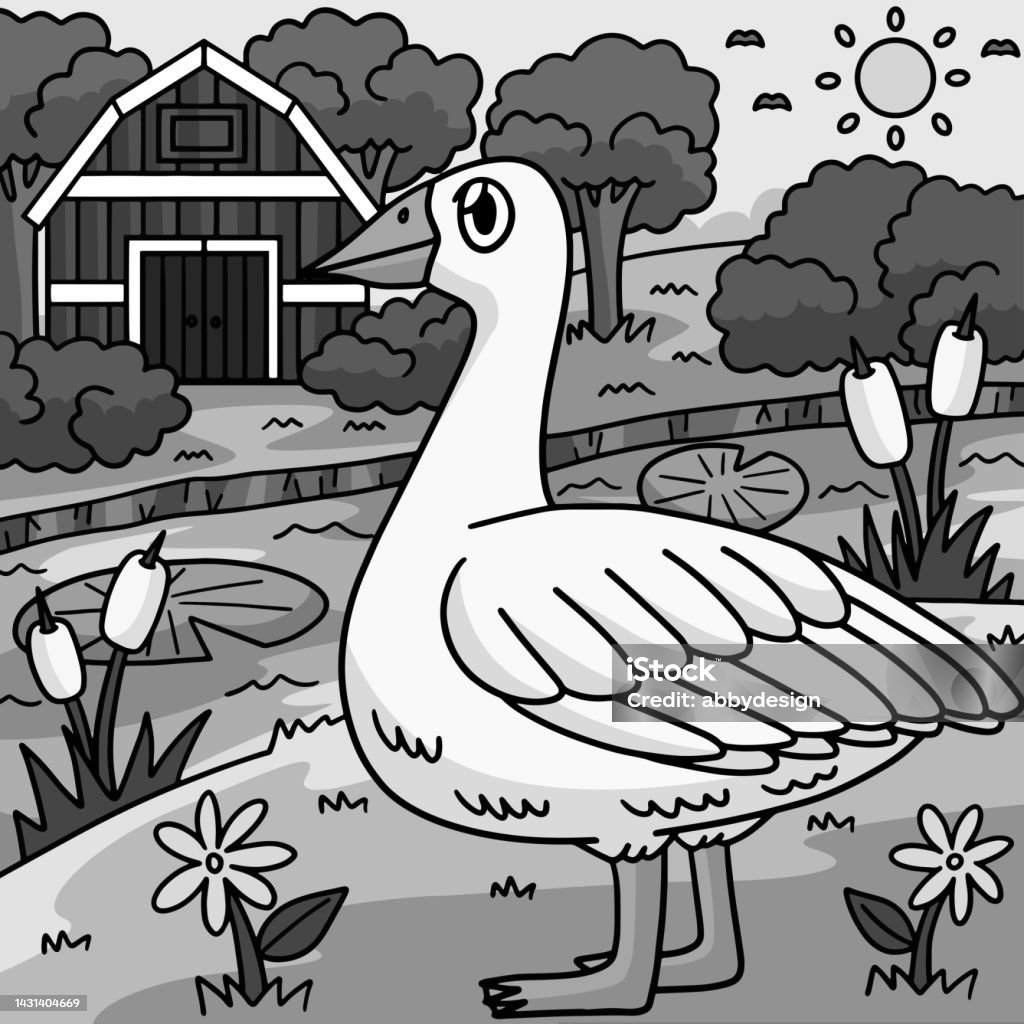

In [ ]:
gray_image = image.convert('L')
gray_image

In [ ]:
gray_image = np.array(gray_image)
N = gray_image.shape[0] # Mengambil jumlah baris pixel pada gambar

F = fft.fft2(gray_image) # Mengubah gambar dari domain spasial ke domain frekuensi (Fourier Transform)
D = constructDuv(N) # Menghitung jarak

Ideal Filtering

In [ ]:
Dos = np.array([10, 20, 40, 100]) # Cut-off frequency

In [ ]:
gsILP, gsIHP, IRunningTime = computeIdealFilters(gray_image, F, D, Dos)

Ideal Filtering


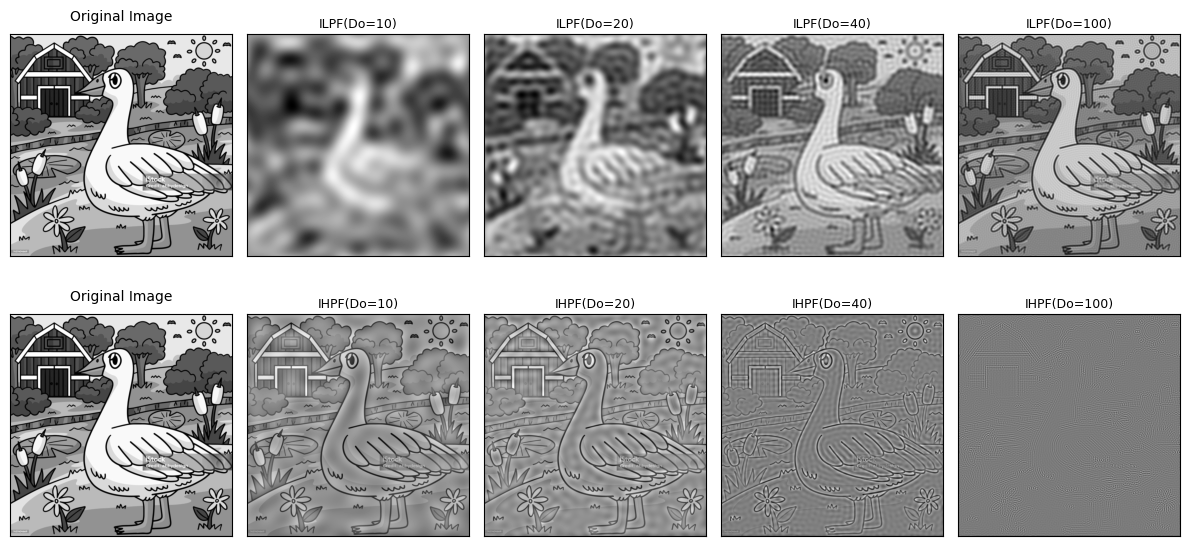

In [ ]:
print('Ideal Filtering')
visualizeFilteringResults(gray_image, F, gsILP, gsIHP, Dos, 'Ideal')

Butterworth Filtering

In [ ]:
ns = np.ones(Dos.shape[0])*2
gsBLP, gsBHP, BRunningTime = computeButterFilters(image, F, D, Dos, ns)

<ipython-input-6-acaabaedcbd1>:8: RuntimeWarning: divide by zero encountered in divide
  H = 1.0/(1.0 + ((Do/D)**(2*n)))


Butterworth Filtering


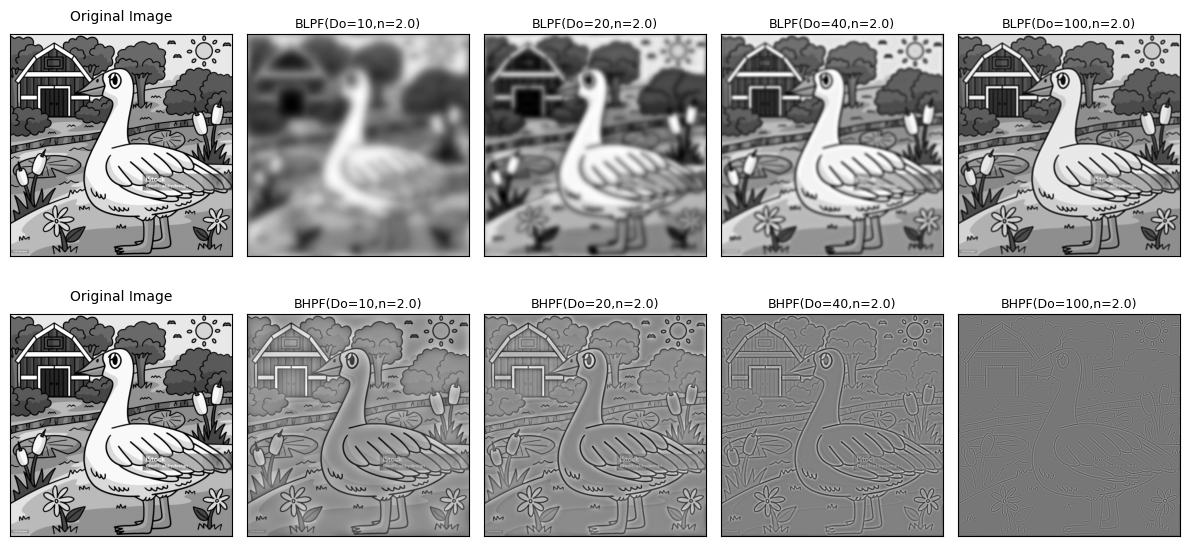

In [ ]:
print('Butterworth Filtering')
visualizeFilteringResults(gray_image, F, gsBLP, gsBHP, Dos, 'Butterworth', ns.astype(float))

## Membandingkan Running Time antara Ideal Filtering dan Butterworth Filtering

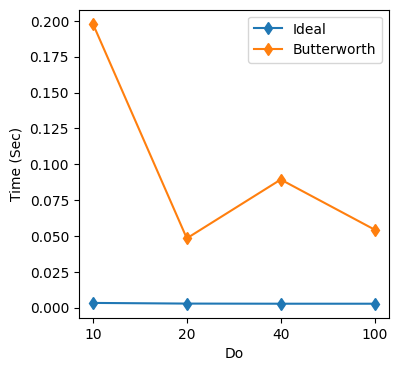

In [ ]:
fig = plt.figure(figsize=[4,4])
numDo = len(IRunningTime)

plt.plot(range(numDo), IRunningTime, '-d')
plt.plot(range(numDo), BRunningTime, '-d')

xlabels = [str(int(Do)) for Do in Dos]
plt.xticks(range(numDo), xlabels)
plt.xlabel("Do")
plt.ylabel("Time (Sec)")
plt.legend(['Ideal', 'Butterworth'], loc=0)
plt.show()

## Butterworth Filtering menggunakan value n dengan constant cut-off frequency

In [ ]:
Dos = np.ones(4, dtype=int)*10 #Constant cut-off frequency
ns = [1, 2, 5, 20]

gsBLP, gsBHP, _ = computeButterFilters(image, F, D, Dos, ns)

<ipython-input-6-acaabaedcbd1>:8: RuntimeWarning: divide by zero encountered in divide
  H = 1.0/(1.0 + ((Do/D)**(2*n)))


Butterworth Filtering


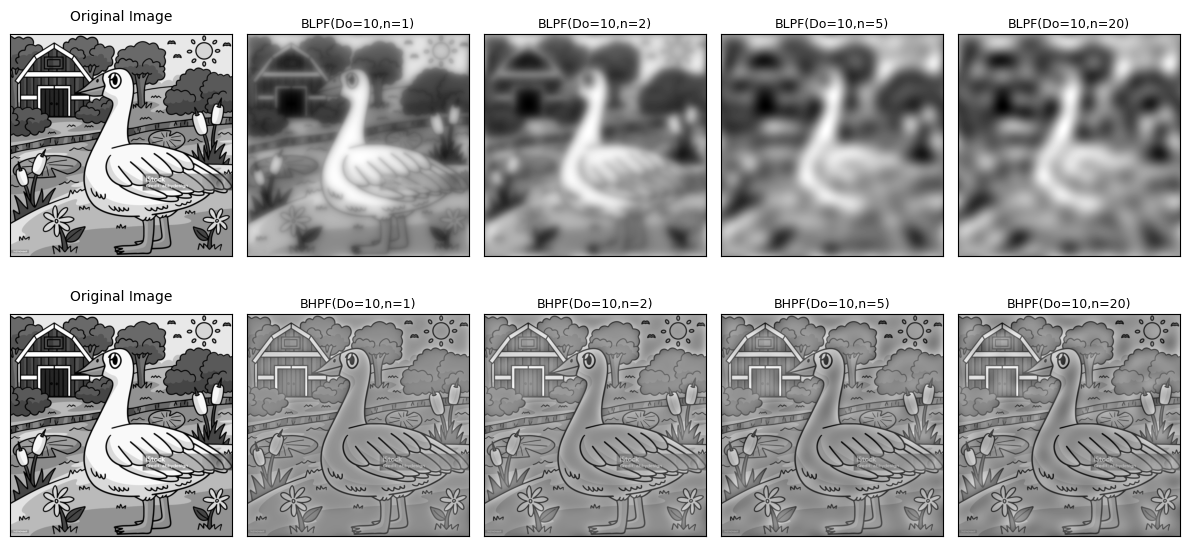

In [ ]:
print('Butterworth Filtering')
visualizeFilteringResults(gray_image, F, gsBLP, gsBHP, Dos, 'Butterworth', ns)